# Dual Recall data fitting

We will first try to fit the summary statistics, and then check if we can fit the loglikelihoods directly.

This should also let us debug likelihood fitting.


In [1]:
import os
import numpy as np
import experimentlauncher
import load_experimental_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import plots_experimental_data
import utils
%matplotlib inline

## Checking Dual Recall data

In [2]:
data_dualrecall = load_experimental_data.load_data_dualrecall(fit_mixture_model=True)
data_pd = data_dualrecall['panda']

reloaded mixture model from cache /Users/lmatthey/Documents/other/dbox/experimental_data/DualRecall_Bays/em_dualrecall_allitems.pickle


Need to be careful with conditions...


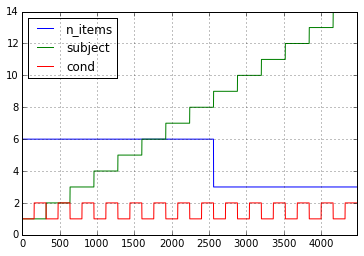

In [108]:
data_pd[['n_items', 'subject', 'cond']].plot()
print 'Need to be careful with conditions...'

## Reloading random fit_mixturemodel samples from model

Hopefully they get something interesting, let's see.

In [4]:
%cd /Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel/
%run reloader_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py

/Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel
Reloader data generated from  generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
Running  /Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel/reloader_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615.py
/Users/lmatthey/Documents/other/dbox/runs_experiments_local/dualrecall_fitmixturemodel/generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615_numrepetitions3/generator_dualrecallfitmixturemodel_random_fitmixturemodel_Msigmaxratio_290615_numrepetitions3-launcher_do_fit_mixturemodel_dualrecall-0098cbc3-0e7c-42a6-b480-0118178ea4d6.n

In [5]:
#### SETUP
#
# savedata = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [6]:
# Extract data
result_em_fits = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_dist_dualrecall_angle = np.array(data_pbs.dict_arrays['result_dist_dualrecall_angle']['results_flat'])
result_dist_dualrecall_angle_emmixt_KL = np.array(data_pbs.dict_arrays['result_dist_dualrecall_angle_emmixt_KL']['results_flat'])
result_dist_dualrecall_colour = np.array(data_pbs.dict_arrays['result_dist_dualrecall_colour']['results_flat'])
result_dist_dualrecall_colour_emmixt_KL = np.array(data_pbs.dict_arrays['result_dist_dualrecall_colour_emmixt_KL']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_em_fits']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_em_fits']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

def str_best_params(best_i, result_dist_to_use):
    return ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [7]:
# Load ground truth
data_dualrecall = load_experimental_data.load_data_dualrecall(fit_mixture_model=True)

reloaded mixture model from cache /Users/lmatthey/Documents/other/dbox/experimental_data/DualRecall_Bays/em_dualrecall_allitems.pickle


In [8]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1
result_parameters_flat = result_parameters_flat[filter_data]

result_em_fits = result_em_fits[filter_data]
result_dist_dualrecall_angle = result_dist_dualrecall_angle[filter_data]
result_dist_dualrecall_angle_emmixt_KL = result_dist_dualrecall_angle_emmixt_KL[filter_data]
result_dist_dualrecall_colour = result_dist_dualrecall_colour[filter_data]
result_dist_dualrecall_colour_emmixt_KL = result_dist_dualrecall_colour_emmixt_KL[filter_data]

all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]

Size post-filter:  251


In [9]:
# Compute lots of averages over the repetitions
result_em_fits_avg = utils.nanmean(result_em_fits, axis=-1)
result_dist_dualrecall_angle_avg = utils.nanmean(result_dist_dualrecall_angle, axis=-1)
result_dist_dualrecall_angle_emmixt_KL_avg = utils.nanmean(result_dist_dualrecall_angle_emmixt_KL, axis=-1)
result_dist_dualrecall_colour_avg = utils.nanmean(result_dist_dualrecall_colour, axis=-1)
result_dist_dualrecall_colour_emmixt_KL_avg = utils.nanmean(result_dist_dualrecall_colour_emmixt_KL, axis=-1)

In [10]:
result_overall_dist_dualrecall_angle_avg = np.nansum(result_dist_dualrecall_angle_avg, axis=-1)
result_overall_dist_dualrecall_colour_avg = np.nansum(result_dist_dualrecall_colour_avg, axis=-1)

In [11]:
# Get the best fitting parameters
max_best_params = 10
best_params_em_angle = np.argsort(result_overall_dist_dualrecall_angle_avg)
best_params_em_colour = np.argsort(result_overall_dist_dualrecall_colour_avg)
best_params_kl_angle = np.argsort(result_dist_dualrecall_angle_emmixt_KL_avg)
best_params_kl_colour = np.argsort(result_dist_dualrecall_colour_emmixt_KL_avg)

### Angle fits

In [13]:
[str_best_params(best_ind, result_overall_dist_dualrecall_angle_avg) for best_ind in best_params_em_angle[:max_best_params]]

['M 141.0000 ratio_conj 0.8582 sigmax 0.1786 >> 0.263715',
 'M 107.0000 ratio_conj 0.7570 sigmax 0.1106 >> 0.534915',
 'M 116.0000 ratio_conj 0.8621 sigmax 0.1456 >> 0.559484',
 'M 99.0000 ratio_conj 0.8182 sigmax 0.1389 >> 0.733813',
 'M 95.0000 ratio_conj 0.8526 sigmax 0.1477 >> 0.763687',
 'M 109.0000 ratio_conj 0.7431 sigmax 0.1133 >> 0.837666',
 'M 42.0000 ratio_conj 0.8571 sigmax 0.0197 >> 0.960749',
 'M 69.0000 ratio_conj 0.7101 sigmax 0.0690 >> 1.437322',
 'M 52.0000 ratio_conj 0.6923 sigmax 0.0309 >> 1.451540',
 'M 90.0000 ratio_conj 0.7111 sigmax 0.1158 >> 1.796035']

In [86]:
weighting_power = 1.0
weighting_em = 4.
weighting_kl = 1.
weighting_sum = weighting_em + weighting_kl
weighting_em /= weighting_sum
weighting_kl /= weighting_sum

best_score = np.inf
best_param_total = -1
for param_ind in np.arange(best_params_kl_angle.size):
    curr_score = weighting_em*(np.where(best_params_em_angle == param_ind)[0][0])**weighting_power  \
                  + weighting_kl*(np.where(best_params_kl_angle == param_ind)[0][0])**weighting_power
                  
    if curr_score < best_score:
        best_param_total = best_params_kl_angle[np.where(best_params_kl_angle == param_ind)[0][0]]
        best_score = curr_score

print best_param_total, curr_score, np.where(best_params_em_angle == best_param_total)[0][0], np.where(best_params_kl_angle == best_param_total)[0][0]


86 122.8 1 14


#### BEST FIT FOR ANGLE ARE:

In [106]:
print result_em_fits_avg[best_param_total]
print str_best_params(best_param_total, result_overall_dist_dualrecall_angle_avg)
print '\n Experimental fits: \n ', '\n  '.join(["%s: %s" % (k, data_dualrecall['em_fits_angle_nitems']['mean'][6][k]) \
                                          for k in ('kappa', 'mixt_target', 'mixt_nontargets', 'mixt_random', 'train_LL', 'bic')])

[8.42182657084591 0.5938672818177152 0.3684461235462198 0.03768659463606506
 -249.56925915692293 541.5250572462301]
M 107.0000 ratio_conj 0.7570 sigmax 0.1106 >> 0.534915

 Experimental fits: 
  kappa: 7.74025549749
  mixt_target: 0.518144258181
  mixt_nontargets: 0.463100018013
  mixt_random: 0.0187557238061
  train_LL: -201.949542521
  bic: 443.573476301


### Colour fits


In [48]:
[str_best_params(best_ind, result_overall_dist_dualrecall_colour_avg) for best_ind in best_params_em_colour[:max_best_params]]

['M 68.0000 ratio_conj 0.9412 sigmax 0.4479 >> 0.404056',
 'M 44.0000 ratio_conj 0.8182 sigmax 0.4471 >> 0.566378',
 'M 25.0000 ratio_conj 1.0000 sigmax 0.3951 >> 0.599065',
 'M 16.0000 ratio_conj 1.0000 sigmax 0.3900 >> 0.650742',
 'M 29.0000 ratio_conj 0.8621 sigmax 0.4474 >> 0.660980',
 'M 94.0000 ratio_conj 0.6809 sigmax 0.4947 >> 0.672682',
 'M 65.0000 ratio_conj 0.7538 sigmax 0.4225 >> 0.728741',
 'M 55.0000 ratio_conj 0.8909 sigmax 0.4124 >> 0.771877',
 'M 31.0000 ratio_conj 0.8065 sigmax 0.4883 >> 0.802022',
 'M 70.0000 ratio_conj 0.9143 sigmax 0.3289 >> 0.855203']

In [83]:
weighting_power = 2.0
weighting_em = 1.
weighting_kl = 1.
weighting_sum = weighting_em + weighting_kl
weighting_em /= weighting_sum
weighting_kl /= weighting_sum

best_score = np.inf
best_param_colour_total = -1
for param_ind in np.arange(best_params_kl_colour.size):
    curr_score = weighting_em*(np.where(best_params_em_colour == param_ind)[0][0])**weighting_power  \
                  + weighting_kl*(np.where(best_params_kl_colour == param_ind)[0][0])**weighting_power
                  
    if curr_score < best_score:
        best_param_colour_total = best_params_kl_colour[np.where(best_params_kl_colour == param_ind)[0][0]]
        best_score = curr_score

print best_param_colour_total, curr_score, np.where(best_params_em_colour == best_param_colour_total)[0][0], np.where(best_params_kl_colour == best_param_colour_total)[0][0]


202 7178.0 9 82


#### Best fits for colours are:

In [107]:
print result_em_fits_avg[best_param_colour_total]
print str_best_params(best_param_colour_total, result_overall_dist_dualrecall_colour_avg)

print '\n Experimental fits: \n ', '\n  '.join(["%s: %s" % (k, data_dualrecall['em_fits_colour_nitems']['mean'][6][k]) \
                                          for k in ('kappa', 'mixt_target', 'mixt_nontargets', 'mixt_random', 'train_LL', 'bic')])

[1.8590778514561384 0.450776285869771 0.5486278940164214
 0.0005958201138076901 -341.6335333451734 725.6536056227311]
M 70.0000 ratio_conj 0.9143 sigmax 0.3289 >> 0.855203

 Experimental fits: 
  kappa: 1.13637891333
  mixt_target: 0.806413983103
  mixt_nontargets: 0.190025472633
  mixt_random: 0.00356054426429
  train_LL: -237.052444769
  bic: 513.744239747


** => Quite horrible fits... **

Again similar issue as in earlier fits:

It's really hard to get low $\kappa$ with high mixt_target, because increasing $\sigma_x$ leads to increased chance of mistakes...

The weighting shows this effect quite nicely, either the _em or the _colour best param is getting chosen in the overall best parameter determination